---

# **Getting Started: `dlt` Resources and Sources** 👩‍💻🚀

**Here, you will learn or brush up on how to:**
- Run a simple pipeline with toy data
- Explore the loaded data using:
  -  The Streamlit app integration
  - `dlt`'s sql_client
- Use `dlt` resources and sources

# Config

In [4]:
from lib import common

In [5]:
common.yo()

Hello World


---
##  **(A) Run a simple pipeline with toy data**


Install `dlt` with DuckDB as destination:

In [11]:
# %%capture
!pip install "dlt[duckdb]"

/Users/ddoni/Projects/local_lab/elt-with-dlt


Define a list of Python dictionaries, which will be your toy data:

In [1]:
data = [{"id": "9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8", "name": "Harry Potter"}, {"id": "4c7e6819-a91a-45b2-a454-f931e4a7cce3", "name": "Hermione Granger"}]

Import `dlt` and create a simple pipeline:

In [2]:
import dlt

pipeline = dlt.pipeline(
    pipeline_name="quick_start",
    destination="duckdb",
    dataset_name="mydata",
)

Run your pipeline and print the load info:

In [3]:
load_info = pipeline.run(data, table_name="students")

print(load_info)

Pipeline quick_start load step completed in 1.08 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/ddoni/Projects/local_lab/elt-with-dlt/quick_start.duckdb location to store data
Load package 1728414039.172103 is LOADED and contains no failed jobs


> **What just happened?**:  `dlt` created a schema called 'mydata' with the table 'students' in it and stored it in DuckDB.

 ---
 ## **(B) Explore the loaded data using**

 ---
 ### **(0) The Streamlit app integration**

Now, in order to see what was loaded into DuckDB, you can use `dlt`'s Streamlit integration. However, Colab is a remote environment, and without tunneling services, you can't access localhost directly - so try this out locally!

Install streamlit:

```
pip install streamlit
```

Visualize the data:
```
dlt pipeline quick_start show
```
This command will have an output like:

```
Found pipeline quick_start in /var/dlt/pipelines

Collecting usage statistics. To deactivate, set browser.gatherUsageStats to false.


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.90.201.33:8501
```

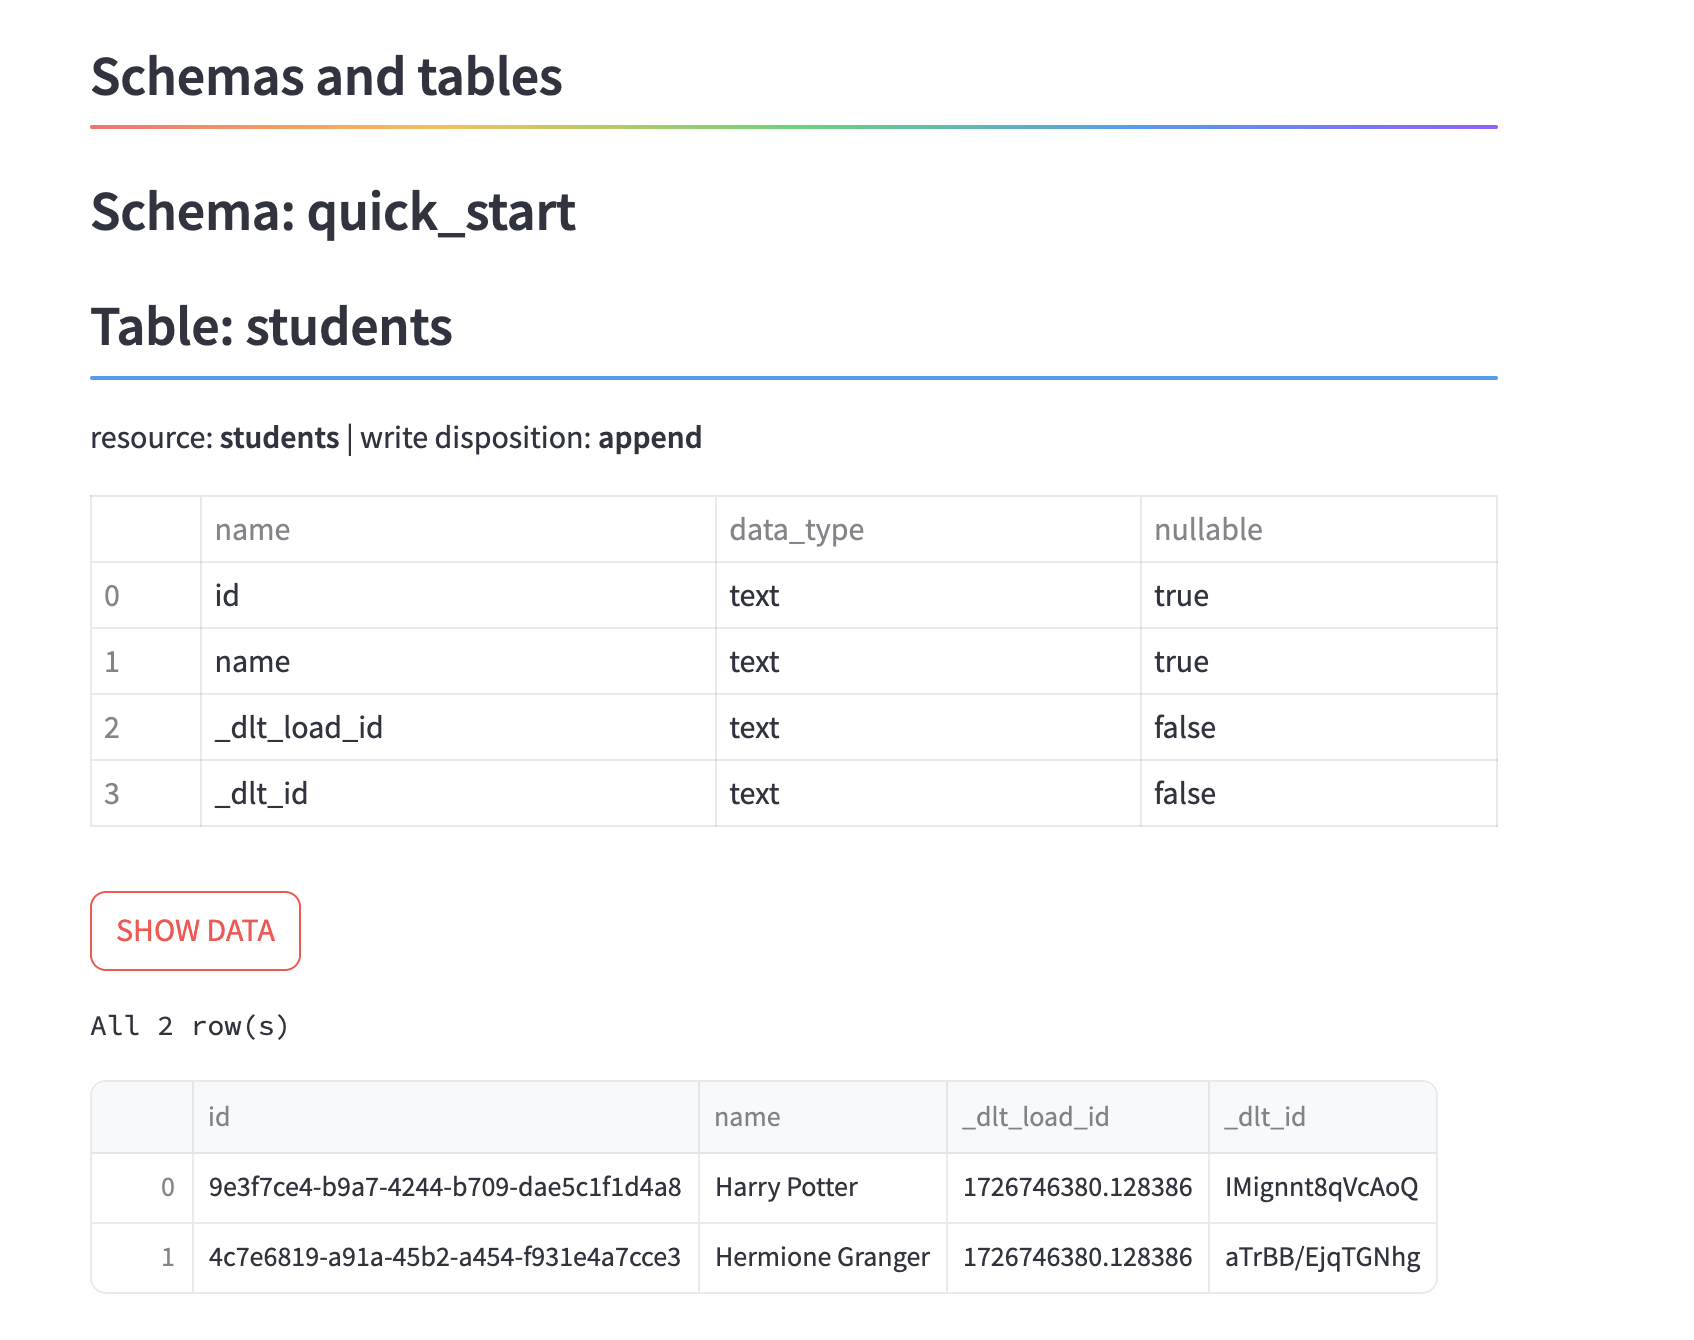

 ---
 ### **(1) `dlt`'s `sql_client`**

> In addition to the Streamlit app, we can explore and query the data using the `dlt` `sql_client`.

Start a connection to your database with `pipeline.sql_client()` and execute a query to get all data from the `students` table:

In [ ]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM students") as cursor:
        print(cursor.df())

                                     id              name        _dlt_load_id  \
0  9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8      Harry Potter  1727692410.4297216   
1  4c7e6819-a91a-45b2-a454-f931e4a7cce3  Hermione Granger  1727692410.4297216   
2  9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8      Harry Potter  1727698958.1619592   
3  4c7e6819-a91a-45b2-a454-f931e4a7cce3  Hermione Granger  1727698958.1619592   

          _dlt_id  
0  vhEFDlcmJ5KYpg  
1  6u6if8EuR+rgtQ  
2  5pgp6IRTgyIiGQ  
3  djehREbRDjWwAw  


Using the code from the previous cell, fetch the data from the `students` table into a dataframe and count the number of users:

In [ ]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM students") as table:
        users = table.df()

user_count = users.shape[0]

print(f"Number of students: {user_count}")

Number of students: 2


---
## **(C) Use `dlt` resources and sources**

---
### **(0) `dlt` resources**

In the previous section, we simply used a list of dictionaries that essentially represents the `students` table.

A better way is to wrap it in the `@dlt.resource` decorator which denotes a logical grouping of data within a data source, typically holding data of similar structure and origin:

In [ ]:
@dlt.resource(table_name='new_students')
def my_dict_list():
    data = [{"id": "9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8", "name": "Harry Potter"}, {"id": "4c7e6819-a91a-45b2-a454-f931e4a7cce3", "name": "Hermione Granger"}]
    yield data

> **Why is it a better way?** This allows you to use `dlt` functionalities to the fullest that follow DE best practices, including incremental loading.

Try running the pipeline with the `my_dict_list` resource:

In [ ]:
load_info = pipeline.run(my_dict_list)
print(load_info)

Pipeline quick_start load step completed in 1.07 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/quick_start.duckdb location to store data
Load package 1727699197.1288643 is LOADED and contains no failed jobs


Check what was loaded to the `new_users` table:

In [ ]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM new_students") as table:
        users = table.df()

print(users)

                                     id              name        _dlt_load_id  \
0  9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8      Harry Potter  1727693076.9029791   
1  4c7e6819-a91a-45b2-a454-f931e4a7cce3  Hermione Granger  1727693076.9029791   

          _dlt_id  
0  NLJb/zP5chNzyg  
1  uQU+i0ZNP2ZPSQ  


Instead of a dict list, the data could also be a/an:
- dataframe
- database query response
- API request response

For dataframes, you would do:

In [ ]:
import pandas as pd

@dlt.resource(table_name='df_data')
def my_df():
  sample_df = pd.DataFrame({
      "id": ["9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8", "4c7e6819-a91a-45b2-a454-f931e4a7cce3"],
      "name": ["Harry Potter", "Hermione Granger"]
  })
  yield sample_df

For database query responses:

In [ ]:
%%capture
!pip install pymysql

In [ ]:
import dlt
from sqlalchemy import create_engine

@dlt.resource(table_name='genome_data')
def get_genome_data():
  engine = create_engine("mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam")
  with engine.connect() as conn:
      query = "SELECT * FROM genome LIMIT 1000"
      rows = conn.execution_options(yield_per=100).exec_driver_sql(query)
      yield map(lambda row: dict(row._mapping), rows)

For API endpoints:

In [ ]:
from dlt.sources.helpers import requests

@dlt.resource(table_name='github_issues')
def get_issues():
  url = "https://api.github.com/repos/dlt-hub/dlt/issues"
  response = requests.get(url)
  yield response.json()

Try loading everything above:

In [ ]:
load_info = pipeline.run([my_df, get_genome_data, get_issues])
print(load_info)

/usr/local/lib/python3.10/dist-packages/pymysql/connections.py:849: UserWarning: Previous unbuffered result was left incomplete
  warnings.warn("Previous unbuffered result was left incomplete")


Pipeline quick_start load step completed in 1.40 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/quick_start.duckdb location to store data
Load package 1726746540.030475 is LOADED and contains no failed jobs


Check which new tables were created:

In [ ]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT table_name FROM information_schema.tables") as table:
        print(table.df())

                 table_name
0                   df_data
1               genome_data
2             github_issues
3  github_issues__assignees
4     github_issues__labels
5              new_students
6                  students
7                _dlt_loads
8       _dlt_pipeline_state
9              _dlt_version


---
### **(1) `dlt` sources**

Now that there are multiple `dlt` resources, each corresponding to a separate table, we can group them into a `dlt` source.



```
                  Source
               /          \
          Resource1  ...  ResourceN

```

> **Why does this matter?**:
- It is more efficient than running your resources separately.
- It organizes both your schema and your code. 🙂
- It enables the option for parallelization.

Here's how it's done:

In [ ]:
@dlt.source
def all_data():
  return my_dict_list, my_df, get_genome_data, get_issues

Only using the source above, load everything into a separate database using a new pipeline:

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="quick_start_new",
    destination="duckdb",
    dataset_name="all_data"
)
load_info = pipeline.run(all_data())
print(load_info)

NameError: name 'all_data' is not defined

---
### **(1) `dlt` transformers**

We now know that `dlt` resources can be grouped into a `dlt` source, represented as:


```
                  Source
               /          \
          Resource1  ...  ResourceN

```

However, imagine a scenario where you need an additional step in between:

```
                  Source
                 /     \
             step        \
             /             \
        Resource1  ...  ResourceN

```

This step could arise, for example, in a situation where:

- Resource1 returns a list of user IDs, and you need to use each of those IDs to retrieve detailed information about the users from a separate API endpoint.

In such cases, you would use `dlt` transformers — special `dlt` resources that can be fed data from another resource:

```
                  Source
                 /     \
          Transformer    \
             /             \
        Resource1  ...  ResourceN

```


Let’s assume Resource1 is:

In [ ]:
@dlt.resource(table_name='new_users')
def my_dict_list():
    data = [{"id": "9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8", "name": "Harry Potter"}, {"id": "4c7e6819-a91a-45b2-a454-f931e4a7cce3", "name": "Hermione Granger"}]
    yield data

We need to get detailed information about both Harry and Hermione from the Harry Potter API `https://hp-api.onrender.com/api/character/{id}` based on their IDs. We would do:

In [ ]:
@dlt.transformer(data_from=my_dict_list, table_name='detailed_info')
def details(data):
    for item in data:
      id = item["id"]
      url = f"https://hp-api.onrender.com/api/character/{id}"
      response = requests.get(url)
      yield response.json()

Run the pipeline:

In [ ]:
import requests
load_info = pipeline.run(details())
print(load_info)

Pipeline quick_start load step completed in 1.16 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/quick_start.duckdb location to store data
Load package 1727699437.3287811 is LOADED and contains no failed jobs


Alternatively, we could do:

In [ ]:
@dlt.resource(table_name='new_users')
def my_dict_list():
    data = [{"id": "9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8", "name": "Harry Potter"}, {"id": "4c7e6819-a91a-45b2-a454-f931e4a7cce3", "name": "Hermione Granger"}]
    yield from data # This would yield one item at a time

@dlt.transformer(data_from=my_dict_list, table_name='detailed_info')
def details(data_item): # Transformer receives one item at a time
    id = data_item["id"]
    url = f"https://hp-api.onrender.com/api/character/{id}"
    response = requests.get(url)
    yield response.json()

load_info = pipeline.run(details())
print(load_info)

Pipeline quick_start_new load step completed in 1.15 seconds
1 load package(s) were loaded to destination duckdb and into dataset all_data
The duckdb destination used duckdb:////content/quick_start_new.duckdb location to store data
Load package 1726746913.6261663 is LOADED and contains no failed jobs


Check the loaded data:

In [ ]:
with pipeline.sql_client() as cursor:
    with cursor.execute_query("SELECT * FROM detailed_info") as table:
        details = table.df()

details

,id,name,species,gender,house,date_of_birth,year_of_birth,wizard,ancestry,eye_colour,...,wand__length,patronus,hogwarts_student,hogwarts_staff,actor,alive,image,_dlt_load_id,_dlt_id,wand__length__v_double
0,9e3f7ce4-b9a7-4244-b709-dae5c1f1d4a8,Harry Potter,human,male,Gryffindor,31-07-1980,1980,True,half-blood,green,...,11.0,stag,True,False,Daniel Radcliffe,True,https://ik.imagekit.io/hpapi/harry.jpg,1727693356.9374847,+VWtA4nz7BKXLA,NaN
1,4c7e6819-a91a-45b2-a454-f931e4a7cce3,Hermione Granger,human,female,Gryffindor,19-09-1979,1979,True,muggleborn,brown,...,NaN,otter,True,False,Emma Watson,True,https://ik.imagekit.io/hpapi/hermione.jpeg,1727693356.9374847,WCBjI518q5l+3Q,10.75
